#### Analisis de Candidatura a Regidor Eddy

In [1]:
import csv
import pandas as pd
import numpy as np
import json

El objetivo de esta funcion es tomar todos los archivos en json que obtuvimos con el script _scrap\_result.py_ el cual  descarga los resultados de las votaciones preferenciales de regidor, que estan denotados por el colegio electoral, los archvos estan nombrados de la forma siguiente _colegio\_numero\_colegio.json_, estos se descargaran en la carptea _data/sde_

El colegio electoral **1004** el archivo con los resultados tendra nombre _colegio\_1004.json_

Tambien se descarga el archivo _colegios.json_ donde esta la relacion de todos los colegios en una circunscripcion dada. 

El archivo _cargos.json_ nos da la relacion de los candidatos o el tipo de votacion.

El archivo _relacion\_circunscripcion\_colegio_sde.csv es un archivo realizado manualmente con las relaciones de los colegios y su circunscripcion. 

In [2]:

def reformat_colums(colegio):
     """dato el colegio dado lee los archivos y los convierte en un dataframe, y reformatea la columna
        votos preferenciales y la convierte en columnas los dato que contiene
     """
     jsondata = pd.read_json(f"data/sde/colegio_{colegio}.json", dtype={"letra": str})
     num_colums = len(jsondata["votosPreferenciales"][0])
     votos = pd.DataFrame(list(jsondata["votosPreferenciales"]))
     votos.columns = ["Casilla_{}".format(x) for x in range(1,num_colums +1)]
     new_votos = votos.map(lambda x: x["votos"])
     new_cat = pd.concat([jsondata,new_votos], axis=1)
     return new_cat

#reformat_colums("2340")


In [3]:
with open("data/sde/colegios.json")as f:
    colegios_json = json.load(f)

colegios = pd.DataFrame(colegios_json["items"])
colegios.head()

,id,letra,municipioId,tieneResultados,count
0,11909,0001,223,True,0
1,11910,0867,223,True,0
2,11911,0867A,223,True,0
3,11912,0868,223,True,0
4,11913,0868A,223,True,0


En la funciones anteriores convertimos colegios.json en un Dataframe, para usar esta informacion del numero de colegio como referncia y proceder a tener toda  la data en un dataframe usando la fucnion _reformat\_columns()_

In [4]:
data_gen = (reformat_colums(colegio) for colegio in colegios["letra"])
results = pd.concat(data_gen, ignore_index=True, )
#new_data = new_data.fillna(-1)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50082 entries, 0 to 50081
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   50082 non-null  int64  
 1   letra                50082 non-null  object 
 2   descripcionLarga     50082 non-null  object 
 3   cargoId              50082 non-null  int64  
 4   cargo                50082 non-null  object 
 5   entidadId            50082 non-null  int64  
 6   entidad              50082 non-null  object 
 7   ordenEntidad         50082 non-null  int64  
 8   votos                50082 non-null  int64  
 9   siglas               50082 non-null  object 
 10  logo                 50082 non-null  object 
 11  validos              50082 non-null  int64  
 12  observados           50082 non-null  int64  
 13  nulos                50082 non-null  int64  
 14  emitidos             50082 non-null  int64  
 15  cantidadCandidatos   50048 non-null 

Basados el resultado anterior vemos filas llenas de N/A cual sera un problema para los calculos.  Mas adelante es validaremos cuales estan en esa situacion y se eliminaran del dataframe. 

Notese que tambien en algunas Casillas tambien tienen valor de N/A y se produjeron al unir los dataframes generados de cada colegio, esto debido a que existen archivos con mas numeros de casillas o candiatos a regidor que otros.

In [5]:
results[results["cantidadCandidatos"].isna()].head()

,id,letra,descripcionLarga,cargoId,cargo,entidadId,entidad,ordenEntidad,votos,siglas,...,Casilla_3,Casilla_4,Casilla_5,Casilla_6,Casilla_7,Casilla_8,Casilla_9,Casilla_10,Casilla_11,Casilla_12
33966,12960,1842,"(00061) - COLEGIO MAX HENRIQUEZ UREÑA,STA. LUC...",61,PREFERENCIAL REGIDOR(A),1,PARTIDO REVOLUCIONARIO MODERNO,1,0,PRM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33967,12960,1842,"(00061) - COLEGIO MAX HENRIQUEZ UREÑA,STA. LUC...",61,PREFERENCIAL REGIDOR(A),2,PARTIDO DE LA LIBERACION DOMINICANA,2,0,PLD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33968,12960,1842,"(00061) - COLEGIO MAX HENRIQUEZ UREÑA,STA. LUC...",61,PREFERENCIAL REGIDOR(A),3,PARTIDO FUERZA DEL PUEBLO,3,0,FP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33969,12960,1842,"(00061) - COLEGIO MAX HENRIQUEZ UREÑA,STA. LUC...",61,PREFERENCIAL REGIDOR(A),4,PARTIDO REVOLUCIONARIO DOMINICANO,4,0,PRD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33970,12960,1842,"(00061) - COLEGIO MAX HENRIQUEZ UREÑA,STA. LUC...",61,PREFERENCIAL REGIDOR(A),5,PARTIDO REFORMISTA SOCIAL CRISTIANO,5,0,PRSC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Quitamos las filas cuyos sean todos N/A vemos en la propiedades del dataframe que se redujo la cantidad de filas.
Lo siguiente sera las filas restantes con diferencias de candidatos que tenga N/A le pondremos -1 para distingir de un candidato que tuvo 0 votos a otro que no existia la casilla en esa circunscripcion. 


In [6]:
s = results["cantidadCandidatos"].notna()

results = results[s]
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50048 entries, 0 to 50081
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   50048 non-null  int64  
 1   letra                50048 non-null  object 
 2   descripcionLarga     50048 non-null  object 
 3   cargoId              50048 non-null  int64  
 4   cargo                50048 non-null  object 
 5   entidadId            50048 non-null  int64  
 6   entidad              50048 non-null  object 
 7   ordenEntidad         50048 non-null  int64  
 8   votos                50048 non-null  int64  
 9   siglas               50048 non-null  object 
 10  logo                 50048 non-null  object 
 11  validos              50048 non-null  int64  
 12  observados           50048 non-null  int64  
 13  nulos                50048 non-null  int64  
 14  emitidos             50048 non-null  int64  
 15  cantidadCandidatos   50048 non-null  floa

In [7]:
results = results.fillna(-1)

Para comprobar si la transformacion de los datos fue correcta comprobamos los datos en crudo del campo votosPreferenciales con los nuevos campos que son Casillas_1 a la Casilla_12 que corresponden las casillas de los candidatos en la boleta electoral.  Podemos validar que los datos coinciden correctamente.

In [8]:
pd.set_option('display.max_colwidth', None)
subset = results.loc[:, "Casilla_1"]
results[["letra", "siglas", "votosPreferenciales", "Casilla_1", "Casilla_6"]].loc[subset > 0].head()


,letra,siglas,votosPreferenciales,Casilla_1,Casilla_6
0,0001,PRM,"[{'titulo': '1', 'votos': 8}, {'titulo': '2', 'votos': 21}, {'titulo': '3', 'votos': 7}, {'titulo': '4', 'votos': 1}, {'titulo': '5', 'votos': 3}, {'titulo': '6', 'votos': 4}, {'titulo': '7', 'votos': 3}, {'titulo': '8', 'votos': 1}, {'titulo': '9', 'votos': 4}, {'titulo': '10', 'votos': 0}, {'titulo': '11', 'votos': 1}, {'titulo': '12', 'votos': 0}]",8.0,4.0
1,0001,PLD,"[{'titulo': '1', 'votos': 5}, {'titulo': '2', 'votos': 9}, {'titulo': '3', 'votos': 4}, {'titulo': '4', 'votos': 1}, {'titulo': '5', 'votos': 1}, {'titulo': '6', 'votos': 0}, {'titulo': '7', 'votos': 1}, {'titulo': '8', 'votos': 0}, {'titulo': '9', 'votos': 0}, {'titulo': '10', 'votos': 0}, {'titulo': '11', 'votos': 0}, {'titulo': '12', 'votos': 1}]",5.0,0.0
2,0001,FP,"[{'titulo': '1', 'votos': 2}, {'titulo': '2', 'votos': 0}, {'titulo': '3', 'votos': 1}, {'titulo': '4', 'votos': 17}, {'titulo': '5', 'votos': 0}, {'titulo': '6', 'votos': 0}, {'titulo': '7', 'votos': 1}, {'titulo': '8', 'votos': 2}, {'titulo': '9', 'votos': 1}, {'titulo': '10', 'votos': 0}, {'titulo': '11', 'votos': 0}, {'titulo': '12', 'votos': 0}]",2.0,0.0
31,0001,PED,"[{'titulo': '1', 'votos': 1}, {'titulo': '2', 'votos': 0}, {'titulo': '3', 'votos': 0}, {'titulo': '4', 'votos': 0}, {'titulo': '5', 'votos': 0}, {'titulo': '6', 'votos': 0}, {'titulo': '7', 'votos': 0}, {'titulo': '8', 'votos': 0}, {'titulo': '9', 'votos': 0}, {'titulo': '10', 'votos': 0}, {'titulo': '11', 'votos': 0}, {'titulo': '12', 'votos': 0}]",1.0,0.0
34,0867,PRM,"[{'titulo': '1', 'votos': 7}, {'titulo': '2', 'votos': 9}, {'titulo': '3', 'votos': 12}, {'titulo': '4', 'votos': 12}, {'titulo': '5', 'votos': 2}, {'titulo': '6', 'votos': 9}, {'titulo': '7', 'votos': 4}, {'titulo': '8', 'votos': 0}, {'titulo': '9', 'votos': 5}]",7.0,9.0


Algo que pudimos notar  en los campos Casilla, es que estos estan en float y los mismos deben ser enteros ya que no existe la mitad de un voto por tanto es mejor cambiar estos campos a integer. 

In [9]:
casillas = results.columns[17:]
results = results.astype({casilla:int for casilla in casillas})
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50048 entries, 0 to 50081
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   50048 non-null  int64  
 1   letra                50048 non-null  object 
 2   descripcionLarga     50048 non-null  object 
 3   cargoId              50048 non-null  int64  
 4   cargo                50048 non-null  object 
 5   entidadId            50048 non-null  int64  
 6   entidad              50048 non-null  object 
 7   ordenEntidad         50048 non-null  int64  
 8   votos                50048 non-null  int64  
 9   siglas               50048 non-null  object 
 10  logo                 50048 non-null  object 
 11  validos              50048 non-null  int64  
 12  observados           50048 non-null  int64  
 13  nulos                50048 non-null  int64  
 14  emitidos             50048 non-null  int64  
 15  cantidadCandidatos   50048 non-null  floa

Vemos el archivo _relacion\_circunscripcion\_colegio.csv_  y los convertimos en data frame. Vemos que el campo colegios es una lista separada por espacio, despues de convertir la data en pandas el campo **Colegios** se convirtio en una lista para su posterior utilizacion. 

In [10]:
relacion_colegio = pd.read_csv("relacion_circunscripcion_colegio_sde.csv")
relacion_colegio = relacion_colegio[relacion_colegio["Circunscripcion"] > 0]
relacion_colegio["Colegios"] = relacion_colegio["Colegios"].str.split()
relacion_colegio.head()

,Municipio,Circunscripcion,Recinto,Sector,Colegios
0,SANTO DOMINGO ESTE,2,COLEG. NTRA. SRA. DEL ROSARIO DE FATIMA,INVI LOS MINA,"[0993, 0993A, 0993B, 0994, 0994A, 0995, 0995A, 0996, 0996A, 1323, 1323A, 1406, 1406A, 1568, 1718, 1774, 1875, 1921, 1994, 2215]"
1,SANTO DOMINGO ESTE,2,ESCUELA PRIMARIA ALTAGRACIA,KATANGA LOS MINA,"[0950, 0950A, 0951, 0951A, 0952, 0952A, 0953, 0953A, 1339, 1339A, 1558, 1559]"
2,SANTO DOMINGO ESTE,2,COMEDOR ECONOMICO,LOS MINA NUEVO,"[1315, 1315A, 1328, 1328A, 2099]"
3,SANTO DOMINGO ESTE,1,CENTRO EDUCATIVO SANTA CLARA,MAQUITERIA VILLA DUARTE,"[1062, 1062A, 1063, 1063A, 1064, 1064A, 1332, 1332A, 1332B, 1410, 1410A, 1684, 1822, 1841, 2051]"
4,SANTO DOMINGO ESTE,2,COLEGIO MAX HENRIQUEZ UREÑA,KATANGA LOS MINA,"[0930, 0930A, 0954, 0954A, 0954B, 0955, 0955A, 0956, 0956A, 1842, 2052]"


Para tener nuestra tabla organizada primero agregamos 4 nuevas columnas a nuestro dataframe cual sus datos los obtendremos de la recien importada tabla de relaciones.

La idea principal es recorrer el dataframe relacion colegios por indice e insertar en el datraframe results los datos principales que son circunscripcion, Municipio, Recinto y Sector.

In [11]:
results.insert(1,"Municipio", "SANTO DOMINGO ESTE")
results.insert(2,"Circunscripcion", "-1")
results.insert(3,"Sector", None)
results.insert(4,"Recinto", None)

In [12]:
count = 0
for idx in relacion_colegio.index:
    col = relacion_colegio.loc[idx,"Colegios"]
    in_colegio = results["letra"].isin(col)
    results.loc[in_colegio, "Circunscripcion"] = relacion_colegio.loc[idx, "Circunscripcion"]
    results.loc[in_colegio, "Recinto"] = relacion_colegio.loc[idx, "Recinto"]
    results.loc[in_colegio, "Sector"] = relacion_colegio.loc[idx, "Sector"]
results.head()
#results["Circunscripcion"] = relacion_colegio["Circunscripcion"]


,id,Municipio,Circunscripcion,Sector,Recinto,letra,descripcionLarga,cargoId,cargo,entidadId,...,Casilla_3,Casilla_4,Casilla_5,Casilla_6,Casilla_7,Casilla_8,Casilla_9,Casilla_10,Casilla_11,Casilla_12
0,11909,SANTO DOMINGO ESTE,1,VILLA FARO,CENTRO EDUCATIVO SANTA MARIA,0001,"(00493) - CENTRO EDUCATIVO SANTA MARIA,CALLE 5TA NO. 90",61,PREFERENCIAL REGIDOR(A),1,...,7,1,3,4,3,1,4,0,1,0
1,11909,SANTO DOMINGO ESTE,1,VILLA FARO,CENTRO EDUCATIVO SANTA MARIA,0001,"(00493) - CENTRO EDUCATIVO SANTA MARIA,CALLE 5TA NO. 90",61,PREFERENCIAL REGIDOR(A),2,...,4,1,1,0,1,0,0,0,0,1
2,11909,SANTO DOMINGO ESTE,1,VILLA FARO,CENTRO EDUCATIVO SANTA MARIA,0001,"(00493) - CENTRO EDUCATIVO SANTA MARIA,CALLE 5TA NO. 90",61,PREFERENCIAL REGIDOR(A),3,...,1,17,0,0,1,2,1,0,0,0
3,11909,SANTO DOMINGO ESTE,1,VILLA FARO,CENTRO EDUCATIVO SANTA MARIA,0001,"(00493) - CENTRO EDUCATIVO SANTA MARIA,CALLE 5TA NO. 90",61,PREFERENCIAL REGIDOR(A),4,...,0,1,0,0,0,0,0,0,0,0
4,11909,SANTO DOMINGO ESTE,1,VILLA FARO,CENTRO EDUCATIVO SANTA MARIA,0001,"(00493) - CENTRO EDUCATIVO SANTA MARIA,CALLE 5TA NO. 90",61,PREFERENCIAL REGIDOR(A),5,...,0,0,0,0,0,0,0,0,0,0


<Axes: title={'center': 'Votos totales por Regidor de Fuerza del pueblo Circunscripcion 1'}>

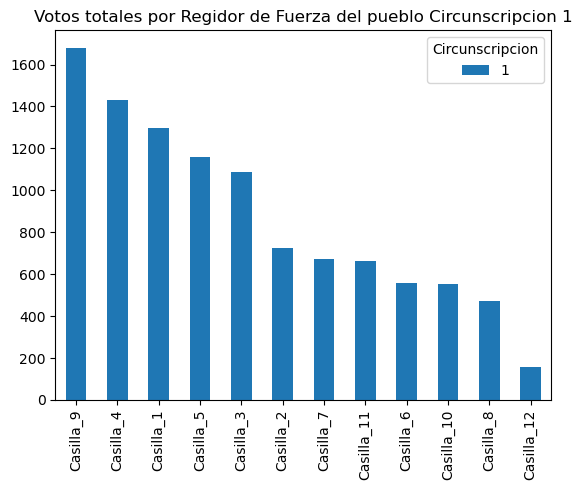

In [13]:
filter = (results.loc[:,"Circunscripcion"] == 1) & (results.loc[:, "siglas"] == "FP")
selected_colums = ["Circunscripcion"] + [ f"Casilla_{x}" for x in range(1,13)]
sum_results = results.loc[filter, selected_colums].groupby("Circunscripcion", group_keys=False).sum()
sum_results.transpose().sort_values(by=1, ascending=False).plot(kind="bar", title="Votos totales por Regidor de Fuerza del pueblo Circunscripcion 1")

Con todos los datos formateados y transformados procedemos a verificar el rendimiento.

Comenzamos comparando los votos totales en la circunscripcion 1 de cada uno de los candidatos a regidores del partido FP.

Nuestro objetivo es el de la casilla 6 como observamos quedo en el 9 lugar con alrededor de 500 votos. 

<Axes: title={'center': 'Recintos que mas votaron por Eddy'}, xlabel='Recinto'>

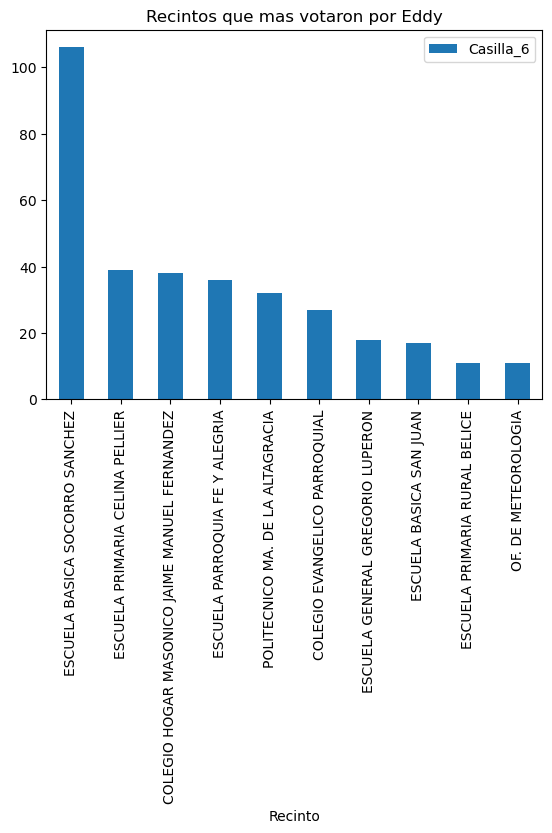

In [14]:
filter = (results.loc[:,"Circunscripcion"] == 1) & (results.loc[:, "siglas"] == "FP")
selected_colums = ["Recinto", "Casilla_6"]
results_rencinto = results.loc[filter, selected_colums].groupby("Recinto").sum()
results_rencinto.sort_values("Casilla_6", ascending=False).head(10).plot(kind="bar", title="Recintos que mas votaron por Eddy")

En los recintos donde el candidato 6 obtuvo mayor cantidad de votos fue la Escuela Socorro Sanchez en el sector de Villa Duarte, siguiendole la Celina Pelier en Los Mameyes. Se verifica que en las zonas mas conocidad es donde se observa la mayor cantidad de votos para este candidato. 

<Axes: title={'center': 'Votos Eddy por Sector (top 10)'}, xlabel='Sector'>

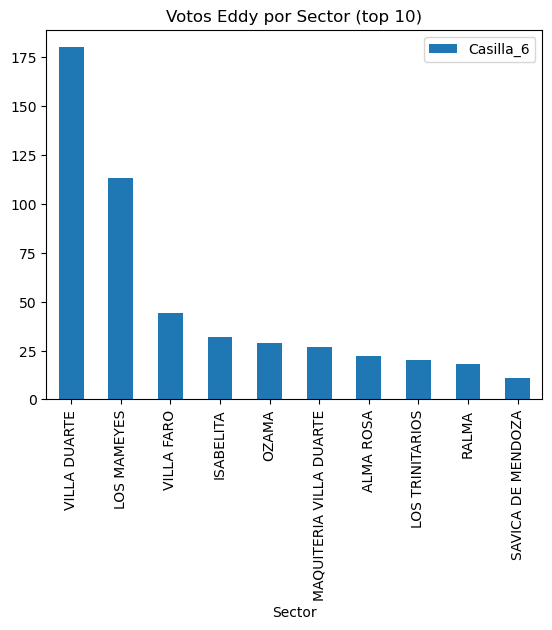

In [15]:
filter = (results.loc[:,"Circunscripcion"] == 1) & (results.loc[:, "siglas"] == "FP")
selected_colums = ["Sector", "Casilla_6",]
results_sector = results.loc[filter, selected_colums].groupby("Sector").sum()
results_sector.sort_values(by="Casilla_6", ascending=False).head(10).plot(kind="bar", title="Votos Eddy por Sector (top 10)")

Como era de esperarse el sector que mas obtuvo votos fue en Villa Duarte y sectores cercanos. 

<Axes: title={'center': 'Porcentaje de recintos cual Eddy obtuvo votos'}, xlabel='Recinto'>

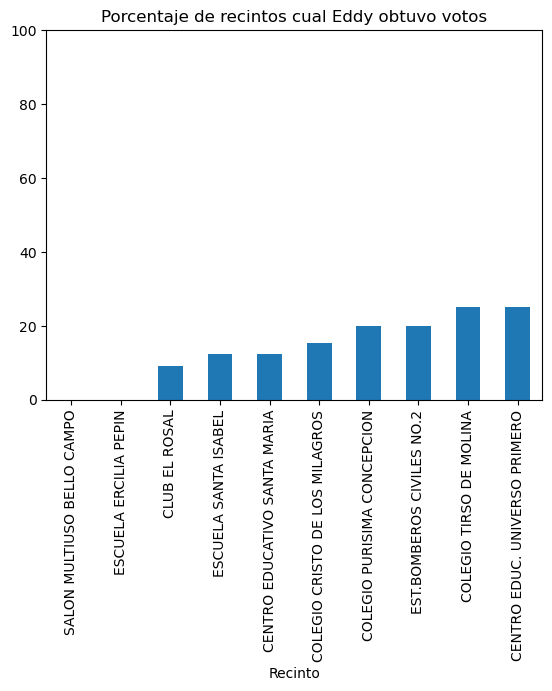

In [16]:
filter = (results.loc[:,"Circunscripcion"] == 1) & (results.loc[:, "siglas"] == "FP")
filter_zero = (results.loc[:,"Circunscripcion"] == 1) & (results.loc[:, "siglas"] == "FP") & (results.loc[:, "Casilla_6"] == 0)
selected_colums = ["Recinto","Casilla_6"]
results_zero = results.loc[filter, selected_colums].groupby("Recinto").count()
results_zero["Casilla_6_zero"] = results.loc[filter_zero, selected_colums].groupby("Recinto").count()
results_zero = results_zero.fillna(0)
results_zero["Percent_zero"] = ((results_zero["Casilla_6"] - results_zero["Casilla_6_zero"]) / results_zero["Casilla_6"]) * 100
results_zero["Percent_zero"].sort_values(ascending=True).head(10).plot(kind="bar", ylim=(0,100), title="Porcentaje de recintos cual Eddy obtuvo votos")

Aqui se observa los recintos donde los votos estan contabilizados a nivel porcentual, donde en cada recinto se tomo en cuenta los colegios donde el candidato tuvo por lo menos 1 voto, comparado  con el total de colegio en cada recinto. Observamos en la grafica que los colegios de Salon Multiuso y ercilia pepin eddy rojas no obtuvo ningun voto en esos colegios. 

<Axes: ylabel='letra'>

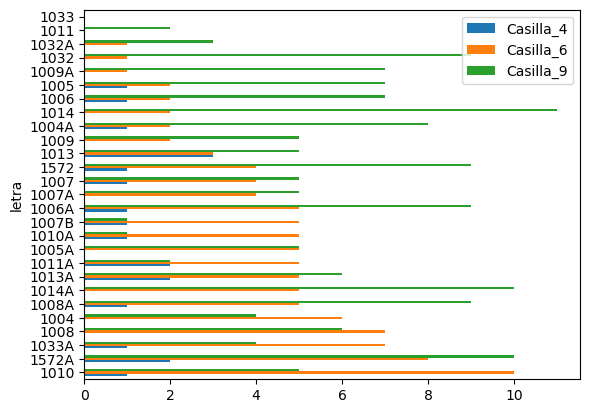

In [17]:
filter = (results.loc[:,"Recinto"] == "ESCUELA BASICA SOCORRO SANCHEZ") & (results.loc[:, "siglas"] == "FP")
selected_colums = ["letra", "Casilla_4","Casilla_6", "Casilla_9"]
results_socorro = results.loc[filter, selected_colums].set_index("letra")
results_socorro.sort_values("Casilla_6", ascending=False).plot(kind="barh")

Para finalizar analizamos el colegio Socorro Sanchez donde el candidato 6 obtuvo la mayor cantidad de votos a relacion con los otros, vemos aqui que comparados con los top 3 de mayor votacion de candidatos del mismo partido, en mayoria de colegios en este recinto el candidato numero 9 del partido obtuvo la mayoria de votos, aunque existen algunas mesas las cuales el candidao 6 supero al de la casilla 9.